# 03 EXPLORATORY DATA ANALYSIS

## Overview of the Jupyter Notebook

The focus of the notebook is to continue exploration of the data. The descriptive statistics are examined on both the categorical and numerical data types looking for any anomalies or patterns. The analysis of the descriptive statistics consisted of reviewing counts, unique values (for high cardinality), top values, and frequencies for categorical features and counts, average (mean), minimum, quartiles, and maximum values for numerical features. Although no duplicates should exist because there is a unique hard drive snapshot for each day, the absence of duplicate values is confirmed. An inspection of the features is performed through aggregations and plotting. Bivariate plotting such as correlation plots and pairwise plots are leveraged to assess relationships between features.  

## Import modules and libraries  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Pandas configuration

Pandas default maximum columns is 20. The columns from the data transformation effort is 40. Moreover, the float and precision are set to 2 decimals for readability.   

In [2]:
# References
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html

pd.set_option('display.float_format',  '{:,.2f}'.format)
pd.set_option('display.max_columns', 40)
pd.set_option('display.precision', 2)

## Matplotlib and Seaborn configuration

Rather than changing the parameters for each individual plot, parameters are set for the entire notebook.  

In [3]:
# References
# https://stackoverflow.com/questions/27476642/matplotlib-get-rid-of-max-open-warning-output

# Multiple plots are opened and the parameters 
# ('figure.max_open_warning') are updated to suppress the warning.
plt.rcParams.update({'figure.max_open_warning': 0})

# For a cleaner plot, the spines are removed from all axes.
custom_params = {'axes.spines.right': False,
                 'axes.spines.left': False,
                 'axes.spines.top': False,
                 'axes.spines.bottom': False}

# The theme is set to white and the custom parameters ('custom_params')
# are added to the theme. The color codes are set to assist those that
# are colorblind.
sns.set_theme(style="white", rc=custom_params)
sns.set_color_codes('colorblind')

## Notebook functions

In [4]:
# References
# https://stackoverflow.com/questions/61218720/how-would-i-set-the-y-axis-to-be-in-millions

def formatter(x, pos):
    """
    Accepts a value and position, and formats the value to X.X M, and 
    returns the formatted value and plot position.
    
    Keyword arguments:
    x -- the value to be converted
    pos -- the plot position
    """
    return '{0:.1f} M'.format(x/1e6)

In [5]:
# References
# https://stackoverflow.com/questions/35829211/pandas-counting-the-proportion-of-zeros-in-rows-and-columns-of-dataframe

def top_5_values(df, col):
    """
    Accepts a Pandas DataFrame and column, and calculates and returns 
    the value counts for the column, a percentage of the values, and 
    the first 5 results.
    
    Keyword arguments:
    df -- the Pandas DataFrame
    col -- the column in the Pandas DataFrame
    """
    df = (
        df[col]
        .value_counts()
        .to_frame()
        .head()
    ).assign(total=len(df.index), 
                   percent=lambda x: (x[col] / x.total) * 100)
    return df

## Import data from Parquet file to dataframe

The data from the prior notebook was previously saved to a Parquet file and is read into a datafame.  

In [6]:
# The 'pq_path' variable is assigned to the path of the Parquet folder 
# ('q1_2022_seagate.parquet').
pq_path = './data/parquet/q1_2022_seagate.parquet'

In [7]:
# References
# https://pandas.pydata.org/docs/reference/api/pandas.read_parquet.html
# https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html

# Pandas allows reading Parquet Files ('read_parquet') directly.
# PyArrow has more options for reading Parquet Files and can be
# passed to a Pandas DataFrame ('q1_2022_seagate_df').
# The Parquet path ('pq_path' is read into a PyArrow Table
# ('q1_2022_seagate_pa_table'). Category columns are defined in a list
# ('categories') and used to read the PyArrow Table
# ('q1_2022_seagate_pa_table') into a Pandas DataFrame 
# ('q1_2022_seagate_df').
# By casting the categories to a 'category' dtype, memory usage was 
# reduced.
q1_2022_seagate_pa_table = pq.read_table(pq_path)
categories = ['serial_number', 'model', 'capacity_bytes', 'failure']
q1_2022_seagate_df = (
    q1_2022_seagate_pa_table
    .to_pandas(categories=categories, date_as_object=False, 
               self_destruct=True)
)

The Parquet file has been read into a dataframe.  

In [8]:
# Verify the type is Pandas DataFrame ('q1_2022_seagate_df').
type(q1_2022_seagate_df)

pandas.core.frame.DataFrame

The dataframe consists of 9,201,120 columns and 40 rows.  

In [9]:
# Verify the shape of the Pandas DataFrame ('q1_2022_seagate_df').
q1_2022_seagate_df.shape

(9201120, 40)

## Inspect the dataframe

### Information on dataframe

Information on dataframe includes column names, non-null counts, and data types. As previously observed, there are 9,201,120 entries and 40 columns. There are no `null` values due to the previous data transformations in the prior notebook. The `date` is a `datetime64[ns]` data type. The `serial_number`, `model`, and `failure` columns are `category` data types. The `capacity_bytes` and `smart` columns are all `int64` data types. Worth noting, the `failure` column is the the target feature and has two target classes - 0 (`functional`) and 1 (`non-functional`).  

In [10]:
# Pandas DataFrame ('q1_2022_seagate_df') information with full summary
# with memory usage displayed and null counts shown. 
q1_2022_seagate_df.info(verbose=True, 
                        memory_usage=True, 
                        show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9201120 entries, 0 to 9201119
Data columns (total 40 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   date                  9201120 non-null  datetime64[ns]
 1   serial_number         9201120 non-null  category      
 2   model                 9201120 non-null  category      
 3   capacity_bytes        9201120 non-null  category      
 4   failure               9201120 non-null  category      
 5   smart_1_normalized    9201120 non-null  int64         
 6   smart_1_raw           9201120 non-null  int64         
 7   smart_3_normalized    9201120 non-null  int64         
 8   smart_4_normalized    9201120 non-null  int64         
 9   smart_4_raw           9201120 non-null  int64         
 10  smart_5_normalized    9201120 non-null  int64         
 11  smart_5_raw           9201120 non-null  int64         
 12  smart_7_normalized    9201120 non-null  in

### Overview of first and last 5 rows

The first 5 rows are reviewed to ensure that the data in the columns look consistent.  

In [11]:
q1_2022_seagate_df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,2022-01-01,S3001HBH,ST4000DM000,4000787030016,0,111,41705776,91,100,26,100,0,87,564826045,38,55044,100,100,26,100,0,100,0,73,27,100,3,95,11576,27,27,100,0,100,0,200,0,54939,68556580648,370398316667
1,2022-01-01,S3003TK3,ST4000DM000,4000787030016,0,118,169130600,97,100,7,100,0,85,390128894,36,56329,100,100,3,100,0,100,0,72,28,100,0,76,49702,28,28,100,0,100,0,200,0,56060,67729811048,409848867140
2,2022-01-01,S3003W81,ST4000DM000,4000787030016,0,118,189175216,92,100,12,100,0,83,208738421,34,58422,100,100,11,100,0,100,0,83,17,100,2,93,14304,17,17,100,0,100,0,200,0,58377,69088192984,714479920544
3,2022-01-01,S3004E7J,ST4000DM000,4000787030016,0,109,21882992,92,100,10,100,0,87,621911450,38,54620,100,100,10,100,0,100,0,84,16,100,0,93,15804,16,16,100,0,100,0,200,0,54564,60854732600,355300153266
4,2022-01-01,S3004L7F,ST4000DM000,4000787030016,0,117,154406968,92,100,11,100,0,82,187608333,38,54620,100,100,11,100,0,100,0,82,18,100,0,94,12487,18,18,100,0,100,0,200,0,54576,55863048616,338697039483


The last 5 rows are reviewed to ensure that the data in the columns look consistent.  

In [12]:
q1_2022_seagate_df.tail()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
9201115,2022-03-31,ZTN0BHEJ,ST12000NM001G,12000138625024,0,80,109909024,99,100,1,100,0,87,487341148,95,5019,100,100,1,100,0,100,0,69,31,100,0,100,211,31,31,100,0,100,0,200,0,4996,33747256368,47906088444
9201116,2022-03-31,ZTN0BZV4,ST12000NM001G,12000138625024,0,76,38585856,97,100,3,100,0,84,256187033,97,2939,100,100,3,100,0,100,0,79,21,100,0,100,135,21,21,100,0,100,0,200,0,2921,24066520400,96578036396
9201117,2022-03-31,ZTN0F6WE,ST10000NM001G,10000831348736,0,75,32309592,98,100,2,100,0,79,84623606,99,1036,100,100,2,100,0,100,0,74,26,100,0,100,49,26,26,100,0,100,0,200,0,1029,22340154600,14069767910
9201118,2022-03-31,ZTN0H5B2,ST12000NM001G,12000138625024,0,76,41882280,99,100,1,100,0,77,46770891,100,407,100,100,1,100,0,100,0,66,34,100,0,100,22,34,34,100,0,100,0,200,0,405,22682193752,5924259866
9201119,2022-03-31,ZTN0KQXT,ST10000NM001G,10000831348736,0,82,163696568,99,100,1,100,0,82,151455333,98,2345,100,100,1,100,0,100,0,71,29,100,0,100,111,29,29,100,0,100,0,200,0,2330,18866796408,21580465948


### Descriptive statistics on category and numerical data types  

Since calculating descriptive statistics on categorical and numerical data is treated differently, the data is examined by data type.  

For the categorical descriptive statistics, the count is consistent across all columns. There are a signficant amount of unique serial numbers at 103,711. Each column will be addressed in more detail.  

In [13]:
# References
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

# The descriptive statistics are displayed for the Pandas DataFrame 
# ('q1_2022_seagate_df') having columns with category dtypes.
q1_2022_seagate_df.describe(include=['category'])

,serial_number,model,capacity_bytes,failure
count,9201120,9201120,9201120,9201120
unique,103711,14,7,2
top,S3001HBH,ST12000NM0008,12000138625024,0
freq,90,1815216,3033977,9198292


For the numerical descriptive statistics, the count is consistent across all columns. The SMART `raw` values have a very large standard deviation and a drastic minimum and maximum range values. The SMART `normalized` values are more contained within ranges. Also observed are columns with excessive zeros. For instance, the `smart_187_raw` and `smart_188_raw` features have zeros for min, 25%, 50%, and 75%. Each column will be addressed in more detail and the excessive zeros will be specifically addressed.  

In [14]:
# References
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
# https://stackoverflow.com/questions/40347689/dataframe-describe-suppress-scientific-notation

# The descriptive statistics are displayed for the Pandas DataFrame 
# ('q1_2022_seagate_df') having columns with int dtypes.
# The values are without scientific notation and rounded to 2 decimal 
# points.
(
    q1_2022_seagate_df
    .describe(include=['int'])
    .apply(lambda x: x.apply('{0:.0f}'.format))
)

,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
count,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120,9201120
mean,86,121762742,93,100,12,100,37,86,3698545181,70,27082,100,100,10,100,1,100,493010237,70,30,100,120,92,17463,30,30,100,2,100,2,200,4,26773,65064715677,244577599855
std,14,70553742,4,0,155,1,894,5,881017981649,22,19265,0,0,137,4,111,0,7454054048,6,6,0,29556,14,41060,6,6,0,412,0,412,0,4561,19415,22133600862,139301007698
min,32,0,83,71,1,1,0,41,124,25,0,99,71,0,1,0,1,0,38,14,1,0,1,1,14,14,1,0,1,0,1,0,0,0,4400
25%,79,60793828,90,100,3,100,0,83,224953065,48,10699,100,100,3,100,0,100,0,66,25,100,0,88,1033,25,25,100,0,100,0,200,0,10115,54477643054,137610081551
50%,82,121553500,92,100,7,100,0,87,540971545,79,18709,100,100,6,100,0,100,0,70,30,100,1,99,2414,30,30,100,0,100,0,200,0,17666,71381888116,257976206865
75%,84,182888894,97,100,12,100,0,90,937030712,88,45989,100,100,11,100,0,100,0,75,34,100,7,100,25037,34,34,100,0,100,0,200,0,45904,79742564092,342906946054
max,120,244140600,100,100,30082,100,65528,100,281471669508717,100,66319,100,100,30084,100,65535,100,1060873109784,86,62,100,11752992,100,11753363,62,62,100,278136,100,278136,200,8744086,66078,242355942008,2686268219738


### Determine the number of unique values

#### Categorical

A high amount of unique values for categorical values can present issues with high cardinality. The `serial_number` column has a substantial number of unique values at 103,711.  

In [15]:
# Select the 'category' dtypes from the Pandas DataFrame 
# ('q1_2022_seagate_df') and obtain the number of unique values. Return
# the results in a Pandas DataFrame, reseting the index, and renaming
# the columns to 'columns' and 'num_unique'.
(
    q1_2022_seagate_df
    .select_dtypes('category')
    .nunique()
    .to_frame()
    .reset_index()
    .rename(columns={'index': 'columns', 0: 'num_unique'})
)

,columns,num_unique
0,serial_number,103711
1,model,14
2,capacity_bytes,7
3,failure,2


#### Numerical

Numerical features with only a single (distinct) value adds no predictive value to the data. The features with distinct values were addressed in the prior notebook, but a reexamination is worthwhile. The `smart_10_normalized` has the least amount of unique values.  

In [16]:
# Select the 'integer' dtypes from the Pandas DataFrame 
# ('q1_2022_seagate_df') and obtain the number of unique values. Return
# the results in a Pandas DataFrame, reseting the index, and renaming
# the columns to 'columns' and 'num_unique'.
(
    q1_2022_seagate_df
    .select_dtypes('integer')
    .nunique()
    .to_frame()
    .reset_index()
    .rename(columns={'index': 'columns', 0: 'num_unique'})
)

,columns,num_unique
0,smart_1_normalized,82
1,smart_1_raw,7938166
2,smart_3_normalized,18
3,smart_4_normalized,7
4,smart_4_raw,291
5,smart_5_normalized,97
6,smart_5_raw,4683
7,smart_7_normalized,46
8,smart_7_raw,9166270
9,smart_9_normalized,76


### Inspect dataframe for dupclicate values  

There should not be any duplicate rows because a single hard drive snapshot is only created once per day per serial number. However, to verify there are no errors in the data, an inspection is conducted to validate the absence of duplicate rows.  

In [17]:
# References
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
q1_2022_seagate_df[q1_2022_seagate_df.duplicated()]

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw


## Inspect each of the columns  

### The `date` column

The `date` column has a minimum date of 2022-01-01 and a maximum date of 2022-03-31. As expected, the date range encompasses all of the first quarter of 2022.  

In [18]:
# The descriptive statistics are displayed for the 'date' column from 
# the Pandas DataFrame ('q1_2022_seagate_df') and presented as Pandas
# DataFrame.
(
    q1_2022_seagate_df['date']
    .describe(datetime_is_numeric=True)
    .to_frame()
)

,date
count,9201120
mean,2022-02-14 17:39:18.376545024
min,2022-01-01 00:00:00
25%,2022-01-23 00:00:00
50%,2022-02-15 00:00:00
75%,2022-03-09 00:00:00
max,2022-03-31 00:00:00


There are 90 unique dates which represent each day in the first quarter of 2022.  

In [19]:
q1_2022_seagate_df['date'].nunique()

90

The date with the most amount of hard drive snapshots is 2022-02-02 with a frequency of 103,359.  

In [20]:
# The unique values for the 'date' column of the Pandas DataFrame
# ('q1_2022_seagate_df). The 'column is updated from 'date' to 'count'
# and the first row is returned as a Pandas DataFrame.
(
    q1_2022_seagate_df['date']
    .value_counts()
    .to_frame(name='count')
    .head(1)
)

,count
2022-02-22,103359


The date with the least amount of hard drive snapshots is 2022-01-09 with a frequency of 100,941.  

In [21]:
# The unique values for the 'date' column of the Pandas DataFrame
# ('q1_2022_seagate_df). The column is updated from 'date' to 'count'
# and the last row is returned as a Pandas DataFrame.
(
    q1_2022_seagate_df['date']
    .value_counts()
    .to_frame(name='count')
    .tail(1)
)

,count
2022-01-09,100941


In [22]:
# References
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.month.html

# The 'date' column from the Pandas DataFrame ('q1_2022_seagate_df') is
# grouped by the 'date' column by month and aggregated by count. The
# column is updated from 'date' to 'count' and returned as a Pandas
# DataFrame. The 'total' column which is the length of the Pandas 
# DataFrame ('q1_2022_seagate_df) and the 'percent' column which is the 
# 'count' and 'total' columns divided and multiplied by 100. The 
# results are assigned to a the Pandas DataFrame 
# ('q1_2022_seagate_mon_ct_df').
q1_2022_seagate_mon_ct_df = (
    q1_2022_seagate_df['date']
    .groupby([q1_2022_seagate_df['date']
              .dt.month.rename('month')])
    .agg('count')
    .to_frame(name='count')
    .reset_index()
    .assign(total=len(q1_2022_seagate_df.index), 
            percent=lambda x: (x['count'] / x['total']) * 100)
)

The hard drive snapshots count per month look consistent throughout the first quarter of 2022 ranging from 2.9M to 3.2M. February has the lowest amount of hard drive snapshots which is expected given that February has the least amount of days in a month.  

In [23]:
q1_2022_seagate_mon_ct_df

,month,count,total,percent
0,1,3131658,9201120,34.04
1,2,2867760,9201120,31.17
2,3,3201702,9201120,34.80


The monthly snapshots for the first quarter of 2022 are plotted against the average (mean) which shows consistency.  

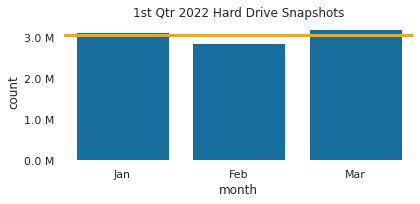

In [24]:
months = ['Jan', 'Feb', 'Mar']

mon_average = q1_2022_seagate_mon_ct_df['count'].mean()

fig, ax = plt.subplots(figsize=(6, 3))

sns.barplot(data=q1_2022_seagate_mon_ct_df, 
            x='month', y='count', 
            color='b', ax=ax)
ax.set_title(label="1st Qtr 2022 Hard Drive Snapshots")
ax.set_xticklabels(labels=months)
ax.yaxis.set_major_formatter(formatter)
ax.axhline(mon_average, color='orange', linewidth=3)

fig.tight_layout()

In [25]:
# The 'date' and 'failure' columns from the Pandas DataFrame 
# ('q1_2022_seagate_df') is grouped by the 'date' and 'failure' columns
# by month and aggregated by count. The data is pivoted using unstack
# and assigned to a Pandas DataFrame 
# ('q1_2022_seagate_mon_ct_fail_df').

# The Pandas DataFrame ('q1_2022_seagate_mon_ct_fail_df') columns are
# renamed to 'functional' and 'non-functional.

# The index of the Pandas DataFrame ('q1_2022_seagate_mon_ct_fail_df') 
# is reset. The 'total' column which is the length of the Pandas 
# DataFrame ('q1_2022_seagate_df) and the 'percent' column which is the 
# 'count' and 'total' columns divide and multiplied by 100. The results 
# are assigned to a the Pandas DataFrame 
# ('q1_2022_seagate_mon_ct_fail_df').
q1_2022_seagate_mon_ct_fail_df = (
    q1_2022_seagate_df[['date', 'failure']]
    .groupby([q1_2022_seagate_df['date'].dt.month.rename('month'),
              'failure'])
    .count()
    .unstack()
)
q1_2022_seagate_mon_ct_fail_df.columns = ['functional', 'non-functional']
q1_2022_seagate_mon_ct_fail_df = (
    q1_2022_seagate_mon_ct_fail_df
    .reset_index()
    .assign(total=lambda x: x['functional'] + x['non-functional'], 
            non_func_percent=lambda x: (x['non-functional'] 
                                     / x.total) * 100)
)

The failures (`non-functional`) for hard drive snapshots per month looks consistent throughout the first quarter of 2022 at 0.03%. There is an obvious imbalance between `functional` and `non-functional` hard drive snapshots.   

In [26]:
q1_2022_seagate_mon_ct_fail_df

,month,functional,non-functional,total,non_func_percent
0,1,3130699,959,3131658,0.03
1,2,2866914,846,2867760,0.03
2,3,3200679,1023,3201702,0.03


Plotting the `functional` and `non-functional` hard drive snapshots side-by-side or stacked does not provide any value as the scales are so drastically different (millions versus hundreds). The `non-functional` hard drive snapshots are lost in such a comparison. Alternatively, the `functional` and `non-functional` can be plotted by month with average (mean) reference to see if there are outliers. The plots look fairly consistent. The `functional` and `non-functional` hard drive snapshots look proportional for each month.  

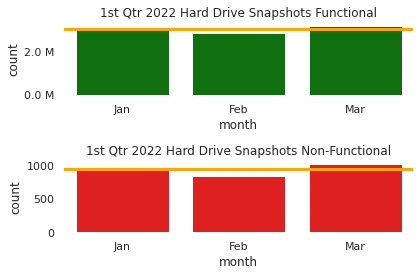

In [27]:
months = ['Jan', 'Feb', 'Mar']

mon_average_f = q1_2022_seagate_mon_ct_fail_df['functional'].mean()
mon_average_nf = q1_2022_seagate_mon_ct_fail_df['non-functional'].mean()

fig, (ax1, ax2) = plt.subplots(2)

# Functional plot
sns.barplot(data=q1_2022_seagate_mon_ct_fail_df, 
            x='month', y='functional', 
            color='green', ax=ax1)
ax1.set_title(label="1st Qtr 2022 Hard Drive Snapshots Functional")
ax1.set_xticklabels(labels=months)
ax1.set_ylabel('count')
ax1.yaxis.set_major_formatter(formatter)
ax1.axhline(mon_average_f, color='orange', linewidth=3)

# Non-functional plot
ax2.set_title(label="1st Qtr 2022 Hard Drive Snapshots Non-Functional")
sns.barplot(data=q1_2022_seagate_mon_ct_fail_df, 
            x='month', y='non-functional',
            color='red', ax=ax2)
ax2.set_xticklabels(labels=months)
ax2.set_ylabel('count')
ax2.axhline(mon_average_nf, color='orange', linewidth=3)

fig.tight_layout()

The dates in the `date` column were useful to produce a deteriorating window in the prior notebook. However, the dates in the `date` column likely do not offer much additional value for predicting a classification of failure, since the date equates to a hard drive snapshot on a given day. The date does not indicate when the hard drive was put into service unless the first snapshot of a specific serial number is obtained. Since the focus of the data is the first quarter of 2022, any first snapshot in a prior quarter would be unknown. For example, if a hard drive was put into service in December 2021, the first snapshot date would not be included in the data.  

***

### The `serial_number` column  

The hard drive snapshots for the `serial_number` column range in count from 90 days (one snapshot for each day in the first quarter of 2022) to 1 day.  

In [28]:
# The unique values are displayed for the 'serial_number' column in the
# Pandas DataFrame ('q1_2022_seagate_df').
(
    q1_2022_seagate_df['serial_number']
    .value_counts()
    .to_frame(name='count')
)

,count
S3001HBH,90
ZL005K1R,90
ZL005K2J,90
ZL005K2H,90
ZL005K2G,90
...,...
ZS5135BY,1
ZA1BJB4Q,1
ZA180YKM,1
Z3015LVE,1


As previously discovered, there are 103,711 unique hard drive serial numbers. The most common serial number is `S3001HBH` with a frequency of 90. Having so many unique values contributes to high cardinality. If label encoding is implemented there would be 103,711 classes. If one hot encoding is implemented there would be 103,711 columns for each unique value. Such an endeavor would result in very high dimensionality.  

In [29]:
# The descriptive statistics are displayed for the 'serial_number'
# column from the Pandas DataFrame ('q1_2022_seagate_df').
(
    q1_2022_seagate_df[['serial_number']]
    .describe()
)

,serial_number
count,9201120
unique,103711
top,S3001HBH
freq,90


An examination of a serial number by failure indicates there are serial numbers that have hard drive snapshots with 7 failures. The results are expected because of the 7 day deterioriating window created in the prior notebook. There are also serial numbers that have hard drive snapshots with 0 failures. Again, the results are expected because there hard drives that have not yet failed.  

In [30]:
q1_2022_seagate_df[(q1_2022_seagate_df['failure'] == 1)]

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
1956,2022-01-01,S300Z5M7,ST4000DM000,4000787030016,1,114,75358600,93,100,7,100,0,87,587872835,34,58116,100,100,7,100,0,100,0,77,23,100,0,79,42224,23,23,100,0,100,0,200,0,57949,70368379624,350942473802
5210,2022-01-01,WDH1BET6,ST4000DM005,4000787030016,1,59,147088624,94,100,8,98,616,94,6765779746,60,35578,100,100,8,49,51,100,0,66,34,100,1460,100,1583,34,34,100,56,100,56,200,0,35437,31437444984,278709245820
6246,2022-01-01,Z302B0XJ,ST4000DM000,4000787030016,1,117,117602984,92,100,10,100,24,89,872849558,31,60488,100,100,10,7,93,100,0,81,19,100,0,73,54397,19,19,100,48,100,48,200,0,60293,75568788872,351126170264
6617,2022-01-01,Z302F1LL,ST4000DM000,4000787030016,1,108,20673944,94,100,6,100,288,88,745126580,31,60475,100,100,6,100,0,100,0,81,19,100,0,75,50982,19,19,100,0,100,0,200,0,60295,74040807856,555403462512
7461,2022-01-01,Z302SZJB,ST4000DM000,4000787030016,1,117,154889520,92,100,24,100,0,85,362795519,38,55023,100,100,24,80,20,100,0,73,27,100,0,94,12729,27,27,100,104,100,104,200,0,54904,69600225408,723482527068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8816518,2022-03-28,ZA13YX97,ST8000DM002,8001563222016,1,71,12953672,84,100,10,93,28256,96,4181917493,47,46670,100,100,10,38,62,100,0,76,24,100,5,74,52170,24,24,100,0,100,0,200,0,46617,93208581456,334371625290
8848244,2022-03-28,ZJV3WAB2,ST12000NM0007,12000138625024,1,79,81358208,89,100,22,100,272,87,551605270,75,22065,100,100,22,100,0,100,0,65,35,100,263,100,1311,35,35,100,0,100,0,200,0,21845,84536755576,395525579254
8857309,2022-03-28,ZL22ZX42,ST16000NM001G,16000900661248,1,75,103700392,90,100,9,100,64,87,550885676,90,9191,100,100,8,2,98,100,4295360518,68,32,100,1,100,1715,32,32,100,8,100,8,200,0,8724,65662366472,114375129096
8919448,2022-03-29,ZA13YNZL,ST8000DM002,8001563222016,1,59,95283168,84,100,22,100,1096,90,936603289,49,45473,100,100,21,95,5,100,4295032833,71,29,100,9,67,66847,29,29,100,0,100,0,200,0,45397,90486911664,333611686324


In [31]:
# A pivot table is created by filtering the 'failure' column from the 
# Pandas DataFrame ('q1_2022_seagate_df') equal to '1' or 
# non-functional, values are set and aggregateded by count on the 
# 'failure' column. The 'serial_number' column is used as the index.
# The 'failure' counts are sorted in descending order.
(
    pd.pivot_table(
        q1_2022_seagate_df[(q1_2022_seagate_df['failure'] == 1)],
        values='failure', index='serial_number', aggfunc='count')
    .sort_values('failure', ascending=False)
)

,failure
serial_number,
Z3057CWN,7
ZA180XX6,7
ZJV2ERGB,7
ZLW0G7HX,7
ZA180YE9,7
...,...
ZA171SG9,0
ZA171SG8,0
ZA171SG7,0


A review of serial number `Z3057CWN`, demonstrates the hard drive snapshots with 7 failures (6 days of hard drive snapshots leading up to the failure and 1 day of hard drive snapshots on the day of failure).  

In [32]:
# The 'Z3057CWN' serial number is filtered from the 'model' column in 
# the Pandas DataFrame ('q1_2022_seagate_df'), sorted by 'date' in
# descending order, with the first 10 rows.
(
    q1_2022_seagate_df[(q1_2022_seagate_df['serial_number'] == 'Z3057CWN')]
    .sort_values('date', ascending=False)
    .head(10)
)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
7665173,2022-03-17,Z3057CWN,ST4000DM000,4000787030016,1,114,71657520,91,100,13,100,72,85,338961521,38,54949,100,100,12,43,57,100,0,74,26,100,0,84,33916,26,26,100,16,100,16,200,0,54549,64652135928,367432041492
7561891,2022-03-16,Z3057CWN,ST4000DM000,4000787030016,1,115,84728120,91,100,13,100,72,84,335423929,38,54926,100,100,12,45,55,100,0,73,27,100,0,84,33916,27,27,100,16,100,16,200,0,54525,64640050504,367255544049
7458666,2022-03-15,Z3057CWN,ST4000DM000,4000787030016,1,117,140086784,91,100,13,100,64,84,332791610,38,54902,100,100,12,57,43,100,0,74,26,100,0,84,33916,26,26,100,0,100,0,200,0,54501,64626788424,367079991019
7355367,2022-03-14,Z3057CWN,ST4000DM000,4000787030016,1,120,242659656,91,100,13,100,64,84,331200466,38,54878,100,100,12,57,43,100,0,74,26,100,0,84,33916,26,26,100,0,100,0,200,0,54477,64616536688,366851269544
7252084,2022-03-13,Z3057CWN,ST4000DM000,4000787030016,1,117,132625896,91,100,13,100,64,84,329370130,38,54854,100,100,12,57,43,100,0,74,26,100,0,84,33916,26,26,100,0,100,0,200,0,54453,64604159840,366646645857
7148801,2022-03-12,Z3057CWN,ST4000DM000,4000787030016,1,116,108123224,91,100,13,100,64,84,327459491,38,54830,100,100,12,57,43,100,0,74,26,100,0,84,33916,26,26,100,0,100,0,200,0,54429,64593163784,366556916997
7045476,2022-03-11,Z3057CWN,ST4000DM000,4000787030016,1,116,112033632,91,100,13,100,64,84,326391694,38,54806,100,100,12,57,43,100,0,74,26,100,0,84,33916,26,26,100,0,100,0,200,0,54406,64583373688,366424807008
6942212,2022-03-10,Z3057CWN,ST4000DM000,4000787030016,0,111,32951224,91,100,13,100,64,84,322884690,38,54782,100,100,12,57,43,100,0,73,27,100,0,84,33916,27,27,100,0,100,0,200,0,54382,64576415272,366120235783
6838914,2022-03-09,Z3057CWN,ST4000DM000,4000787030016,0,116,100841144,91,100,13,100,64,84,319822149,38,54758,100,100,12,57,43,100,0,74,26,100,0,84,33916,26,26,100,0,100,0,200,0,54358,64570592552,365752628834
6735583,2022-03-08,Z3057CWN,ST4000DM000,4000787030016,0,119,211625792,91,100,13,100,64,84,318786941,38,54735,100,100,12,57,43,100,0,74,26,100,0,84,33916,26,26,100,0,100,0,200,0,54334,64561926400,365460598148


One method to address the numerous unique values for the serial number is to bin (group) by the first letter of the serial number. The approach reduces the serial number from 103,711 classes to 3 classes.  

In [33]:
# The 'serial_number' column is selected from the Pandas DataFrame
# ('q1_2022_seagate_df') and the 'serial_number_letter' column is
# created by using a lambda that slices the first letter from the
# 'serial_number' column. The 'serial_number' column is dropped and
# value counts are calculated on the 'serial_number_letter' column and
# returned to Pandas DataFrame with the column name 'counts'.
(
    q1_2022_seagate_df[['serial_number']]
    .assign(serial_number_letter=lambda x: x['serial_number']
            .apply(lambda x: x[0:1]))
    .drop(columns='serial_number')
    .value_counts()
    .to_frame(name='counts')
)

,counts
serial_number_letter,
Z,8731220
S,452719
W,17181


Although there are more hard drives with the serial number starting with `Z` and less hard drives with the serial number starting with `W`, the amount of hard drive snapshots with failures (`non-functional`) are proportional at 0.03% to 0.05% to the hard drive snapshots without failures (`functional`).  

In [34]:
# References
# https://datascientyst.com/flatten-multiindex-in-pandas/

# The 'serial_number' and 'failure' columns are selected from the 
# Pandas DataFrame ('q1_2022_seagate_df') and the 
# 'serial_number_letter' column is created by using a lambda that 
# slices the first letter from the `serial_number' column. The 
# 'serial_number_letter' and 'failure' columns are grouped, and the
# 'failure' column is aggregated by count. To format correctly, 
# unstack, transpose, and reset index are performed. The '0' column is
# renamed to 'functional' and the '1' column is renamed to
# 'non-functional'. The 'total' column is created by using a lambda 
# that adds 'functional' and 'non-functional'. The 'non_func_percent'
# column is created by using a lambda that divides 'non-functional'
# and 'total' and multiplied by 100. The results are sorted by the 
# 'total' column in descending order with the index reset and saved to
# a Pandas DataFrame ('q1_2022_seagate_sn_ltr').
q1_2022_seagate_sn_ltr = (
    q1_2022_seagate_df[['serial_number', 'failure']]
    .assign(serial_number_letter=lambda x: x['serial_number']
            .apply(lambda x: x[0:1]))
    .groupby(by=['serial_number_letter', 'failure'])
    .agg(count=('failure', 'count'))
    .unstack()
    .transpose()
    .reset_index(drop=True)
    .transpose()
    .reset_index()
    .rename(columns={0: 'functional', 1: 'non-functional'})
).assign(total=lambda x: x['functional'] + x['non-functional'], 
            non_func_percent=lambda x: (x['non-functional'] 
                                     / x.total) * 100) \
 .sort_values('total', ascending=False).reset_index(drop=True)

In [35]:
q1_2022_seagate_sn_ltr

,serial_number_letter,functional,non-functional,total,non_func_percent
0,Z,8728522,2698,8731220,0.03
1,S,452597,122,452719,0.03
2,W,17173,8,17181,0.05


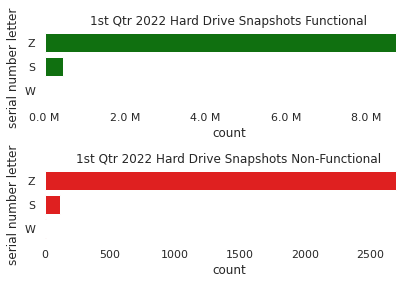

In [36]:
mon_average_f = q1_2022_seagate_sn_ltr['functional'].mean()
mon_average_nf = q1_2022_seagate_sn_ltr['non-functional'].mean()

fig, (ax1, ax2) = plt.subplots(2)

# Functional plot
sns.barplot(data=q1_2022_seagate_sn_ltr, 
            x='functional', y='serial_number_letter', 
            color='green', ax=ax1)
ax1.set_title(label="1st Qtr 2022 Hard Drive Snapshots Functional")
ax1.set_ylabel('serial number letter')
ax1.set_xlabel('count')
ax1.xaxis.set_major_formatter(formatter)

# Non-functional plot
ax2.set_title(label="1st Qtr 2022 Hard Drive Snapshots Non-Functional")
sns.barplot(data=q1_2022_seagate_sn_ltr, 
            x='non-functional', y='serial_number_letter',
            color='red', ax=ax2)
ax2.set_ylabel('serial number letter')
ax2.set_xlabel('count')

fig.tight_layout()

The serial numbers in the `serial_number` column could lead to model bias due to being a unique identifier. Also, due to the quantity of unique serial numbers, there will likely be issues with high cardinality. An option is to bin (group) the serial numbers by first letter. There is not an apparent relationship between the first letter of the serial number and the target (`failure`). Across each group of serial numbers by the first letter there are a proportionate number of `functional` and `non-functional` hard drive snapshots.  

In [37]:
# A lambda function is used to slice the first letter from the serial
# number and assigned to the 'serial_number' column in the Pandas
# DataFrame ('q1_2022_seagate_df').

# The 'serial_number' column in the Pandas DataFrame 
# ('q1_2022_seagate_df') is renamed inplace to 'serial_number_ltr' to 
# reflect the new value.
q1_2022_seagate_df['serial_number'] = (
    q1_2022_seagate_df['serial_number']
    .apply(lambda x: x[0:1])
)
(
    q1_2022_seagate_df
    .rename(columns={'serial_number': 'serial_number_ltr'},
           inplace=True)
)

In [38]:
q1_2022_seagate_df.head()

,date,serial_number_ltr,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,2022-01-01,S,ST4000DM000,4000787030016,0,111,41705776,91,100,26,100,0,87,564826045,38,55044,100,100,26,100,0,100,0,73,27,100,3,95,11576,27,27,100,0,100,0,200,0,54939,68556580648,370398316667
1,2022-01-01,S,ST4000DM000,4000787030016,0,118,169130600,97,100,7,100,0,85,390128894,36,56329,100,100,3,100,0,100,0,72,28,100,0,76,49702,28,28,100,0,100,0,200,0,56060,67729811048,409848867140
2,2022-01-01,S,ST4000DM000,4000787030016,0,118,189175216,92,100,12,100,0,83,208738421,34,58422,100,100,11,100,0,100,0,83,17,100,2,93,14304,17,17,100,0,100,0,200,0,58377,69088192984,714479920544
3,2022-01-01,S,ST4000DM000,4000787030016,0,109,21882992,92,100,10,100,0,87,621911450,38,54620,100,100,10,100,0,100,0,84,16,100,0,93,15804,16,16,100,0,100,0,200,0,54564,60854732600,355300153266
4,2022-01-01,S,ST4000DM000,4000787030016,0,117,154406968,92,100,11,100,0,82,187608333,38,54620,100,100,11,100,0,100,0,82,18,100,0,94,12487,18,18,100,0,100,0,200,0,54576,55863048616,338697039483


***

### The `model` column

There are 14 different hard drive models.  

In [39]:
# The unique values are displayed for the 'model' column in the
# Pandas DataFrame ('q1_2022_seagate_df').
(
    q1_2022_seagate_df['model']
    .value_counts()
    .to_frame(name='count')
)

,count
ST12000NM0008,1815216
ST4000DM000,1670270
ST8000NM0055,1289351
ST12000NM001G,1099542
ST16000NM001G,1092351
ST14000NM001G,966126
ST8000DM002,872319
ST14000NM0138,144328
ST12000NM0007,118346
ST10000NM0086,107126


As previously discovered, there are 14 unique hard drive model numbers. The most common model number is `ST12000NM0008` with a frequency of 1,815,216.  

In [40]:
# The descriptive statistics are displayed for the 'model' column from 
# the Pandas DataFrame ('q1_2022_seagate_df').
(
    q1_2022_seagate_df[['model']]
    .describe()
)

,model
count,9201120
unique,14
top,ST12000NM0008
freq,1815216


The failure (`non-functional`) percent of the hard drive models ranges from 3.24% to 0.01%. The hard drive model (`ST12000NM0117`) with 3.24% failure has a small number of hard drive snapshots at only 873 for the first quarter of 2022.  

In [41]:
# The 'serial_number' and 'failure' columns are selected from the 
# Pandas DataFrame ('q1_2022_seagate_df'). The 'model' and 'failure' 
# columns are grouped, and the 'failure' column is aggregated by count. 
# To format correctly, unstack, transpose, and reset index are 
# performed. The '0' column is renamed to 'functional' and the '1' 
# column is renamed to 'non-functional'. The 'total' column is created 
# by using a lambda that adds 'functional' and 'non-functional'. The 
# 'non_func_percent' column is created by using a lambda that divides 
# 'non-functional' and 'total' and multiplied by 100. The results are 
# sorted by the 'total' column in descending order with the index 
# reset.
(
    q1_2022_seagate_df[['model', 'failure']]
    .groupby(by=['model', 'failure'])
    .agg(count=('failure', 'count'))
    .unstack()
    .transpose()
    .reset_index(drop=True)
    .transpose()
    .reset_index()
    .rename(columns={0: 'functional', 1: 'non_functional'})
).assign(total=lambda x: x['functional'] + x['non_functional'], 
            non_func_percent=lambda x: (x['non_functional'] 
                                     / x.total) * 100) \
 .sort_values('non_func_percent', ascending=False).reset_index(drop=True)

,model,functional,non_functional,total,non_func_percent
0,ST12000NM0117,866,7,873,0.80
1,ST12000NM0007,118230,116,118346,0.10
2,ST10000NM001G,1027,1,1028,0.10
3,ST14000NM0138,144216,112,144328,0.08
4,ST500LM030,20899,14,20913,0.07
5,ST10000NM0086,107070,56,107126,0.05
6,ST4000DM000,1669478,792,1670270,0.05
7,ST8000NM0055,1288791,560,1289351,0.04
8,ST8000DM002,872053,266,872319,0.03
9,ST4000DM005,3330,1,3331,0.03


***

### The `capacity_bytes` column

There are 7 different hard drive capacities. The capacity is in `bytes` which makes interpreting the hard drive storage challenging.  

In [42]:
# The unique values are displayed for the 'capacity_terabytes' column 
# in the Pandas DataFrame ('q1_2022_seagate_df').
(
    q1_2022_seagate_df['capacity_bytes']
    .value_counts()
    .to_frame(name='count')
)

,count
12000138625024,3033977
8001563222016,2161670
4000787030016,1673601
14000519643136,1110454
16000900661248,1092351
10000831348736,108154
500107862016,20913


For modern hard drives, a more common format is `gigabytes (GB)` or `terabytes (TB)`. Since the values for the `bytes` are so large, a more likely representation is `terabytes (TB)`. The `bytes` can be converted to `terabytes (TB)`.  

In [43]:
# References
# https://hextobinary.com/unit/byte/from/B/to/TB

# A lambda function is used to convert bytes to terabytes by 
# multiplying bytes by 1e-12. The terabytes are rounded to 1 decimal
# place and temporarily assigned to the 'capacity_bytes' column in the 
# Pandas DataFrame ('q1_2022_seagate_df').

# The 'capacity_bytes' column in the Pandas DataFrame 
# ('q1_2022_seagate_df') is renamed inplace to 'capacity_terabytes' to 
# reflect the new measurement.
q1_2022_seagate_df['capacity_bytes'] = (
    q1_2022_seagate_df['capacity_bytes']
    .apply(lambda x: round(x * 1e-12, 1))
)
(
    q1_2022_seagate_df
    .rename(columns={'capacity_bytes': 'capacity_terabytes'},
           inplace=True)
)

The hard drive capacity ranges from 0.5 TB (500 GB) to 16 TB. The greatest number of hard drives have a 12.0 TB capacity and the least number of hard drives have a 0.5 TB capacity.  

In [44]:
# The unique values are displayed for the 'capacity_terabytes' column 
# in the Pandas DataFrame ('q1_2022_seagate_df').
(
    q1_2022_seagate_df['capacity_terabytes']
    .value_counts()
    .to_frame(name='count')
)

,count
12.0,3033977
8.0,2161670
4.0,1673601
14.0,1110454
16.0,1092351
10.0,108154
0.5,20913


***

### The `failure` column

The `failure` column is the target. The machine learning models will attempt to classify the `failure` (target) correctly. The `failure` column consists of two values - `0` or `functional` (majority class) and `1` or `non-functional` (minority class).  Comparing the two values, there is an extreme class imbalance that will need to be addressed.  

In [45]:
# The unique values are displayed for the 'failure' column 
# in the Pandas DataFrame ('q1_2022_seagate_df').
(
    q1_2022_seagate_df['failure']
    .value_counts()
    .to_frame(name='count')
)

,count
0,9198292
1,2828


### Balance the data 

The class imbalance presents challenges with plotting. The target variable (`failure`) has over 9M observations for the `0` or `functional` majority class and only 2.8K observations for the `1` or `non-fucntional` minority class. At over 9M observations, plotting requires significant amount of resources. In addition, the distribution can be masked due to the substantial imbalance. As an alternative approach, a sample of the data will be plotted.  
<br>
Since there are 2,828 observations for the `1` or `non-fucntional` class, the `0` or `functional` class can be undersampled to 2,828 observations as well.  

In [46]:
# References
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
# https://stackoverflow.com/questions/56726342/how-to-sample-from-pandas-dataframe-n-rows-from-each-subgroup-uniformly?noredirect=1&lq=1

# The Pandas DataFrame ('q1_2022_seagate_df') is grouped by the
# 'failure' column without group keys. A sample size of 2,828 is 
# selected from each group with a random state of 42 for 
# reproducibility.
q1_2022_seagate_sample_df = (
    q1_2022_seagate_df
    .groupby('failure', group_keys=False)
    .apply(lambda x: x.sample(n=2828, random_state=42))
)
(
    q1_2022_seagate_sample_df[['failure']]
    .value_counts()
    .to_frame(name='count')
)

,count
failure,
0,2828
1,2828


In [47]:
q1_2022_seagate_sample_df.head()

,date,serial_number_ltr,model,capacity_terabytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
8185252,2022-03-22,Z,ST4000DM000,4.00,0,111,32893016,92,100,8,100,0,69,7672283,40,53392,100,100,8,100,0,100,0,80,20,100,0,99,3727,20,20,100,0,100,0,200,0,53366,60334458128,422357384666
5089281,2022-02-20,Z,ST4000DM000,4.00,0,111,38141264,96,100,4,100,0,89,934751295,41,52030,100,100,4,82,18,100,0,75,25,100,0,98,5243,25,25,100,8,100,8,200,0,51976,59397782136,385414326678
4971676,2022-02-19,S,ST4000DM000,4.00,0,119,229603312,92,100,8,100,0,88,769552130,34,58351,100,100,8,100,0,100,0,81,19,100,0,81,38322,19,19,100,0,100,0,200,0,57987,72115039472,523180507717
329928,2022-01-04,Z,ST8000NM0055,8.00,0,82,158663440,86,100,7,100,0,93,2116040215,55,40244,100,100,7,100,0,100,0,70,30,100,2,68,65544,30,30,100,0,100,0,200,0,40224,82444782608,314886004458
3464643,2022-02-04,Z,ST8000DM002,8.00,0,83,204548920,84,100,42,100,0,94,2390122669,50,44176,100,100,43,94,6,100,0,56,44,100,33,69,63550,44,44,100,0,100,0,200,0,44095,88288945232,345363303104


Prior to making the decision to undersample the data, violin and histogram plots were used to compare the distribution of the unsampled and sampled data.  

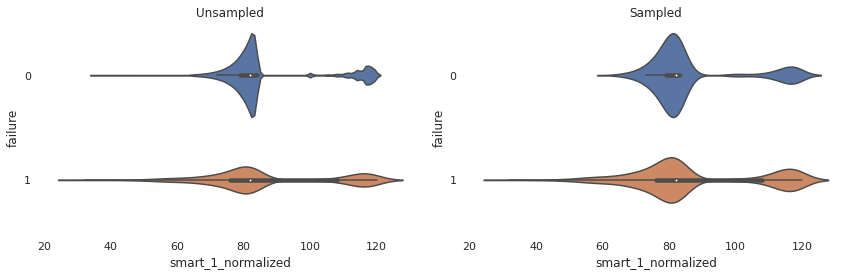

In [48]:
# References
# https://seaborn.pydata.org/generated/seaborn.violinplot.html
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, 
                               figsize=(12, 4))

# Unsampled data
sns.violinplot(data=q1_2022_seagate_df, 
               x='smart_1_normalized', y='failure', ax=ax1)
ax1.set_title(label="Unsampled")

# Sampled data
sns.violinplot(data=q1_2022_seagate_sample_df, 
               x='smart_1_normalized', y='failure', ax=ax2)
ax2.set_title(label="Sampled")

fig.tight_layout()

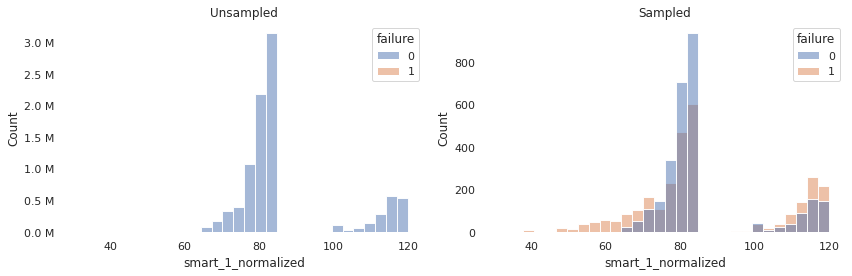

In [49]:
# References
# https://seaborn.pydata.org/generated/seaborn.histplot.html

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, 
                               figsize=(12, 4))

# Unsampled data
sns.histplot(data=q1_2022_seagate_df, 
             x='smart_1_normalized', hue='failure', 
             bins=30, ax=ax1)
ax1.set_title(label="Unsampled")
ax1.yaxis.set_major_formatter(formatter)

# Sampled data
sns.histplot(data=q1_2022_seagate_sample_df, 
             x='smart_1_normalized', hue='failure', 
             bins=30, ax=ax2)
ax2.set_title(label="Sampled")

fig.tight_layout()

Comparing the distribution between the unsampled (left plot) and sampled (right plot) data of `smart_1_normalized`, the `1` or `non-functional` minority class is masked in the unsampled data and visisble on the sampled data. Focusing on the sampled data, the `1` or `non-functional` minority class has more values on the left tail around the 70 and less.  

***

### The `smart` columns  

Wikipedia  provides the following definition of SMART attributes with critical attributes in bold (S.M.A.R.T., 2022).

The critical values are deemed to be a value that might predict a failure (S.M.A.R.T., 2022).  

| ATTRIBUTE | ATTRIBUTE NAME                                   | ATTRIBUTE DESCRIPTION                                                                                                                    |
|-----------|--------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------|
| SMART 1   | Read Error Rate                                  | (Vendor specific raw value.) Stores data related to the rate of hardware read errors that occurred when reading data from a disk surface |
| SMART 3   | Spin-Up Time                                     | Average time of spindle spin up (from zero RPM to fully operational [milliseconds]).                                                     |
| SMART 4   | Start/Stop Count                                 | A tally of spindle start/stop cycles.                                                                                                    |
| **SMART 5**   | Reallocated Sectors Count                        | Count of reallocated sectors.                                                                                                            |
| SMART 7   | Seek Error Rate                                  | (Vendor specific raw value.) Rate of seek errors of the magnetic heads.                                                                  |
| SMART 9   | Power-On Hours                                   | Count of hours in power-on state.                                                                                                        |
| **SMART 10**  | Spin Retry Count                                 | Count of retry of spin start attempts.                                                                                                   |
| SMART 12  | Power Cycle Count                                | This attribute indicates the count of full hard disk power on/off cycles.                                                                |
| **SMART 187** | Reported Uncorrectable Errors                    | The count of errors that could not be recovered using hardware ECC (see attribute 195).                                                  |
| **SMART 188** | Command Timeout                                  | The count of aborted operations due to HDD timeout.                                                                                      |
| SMART 190 | Temperature Difference or Airflow Temperature    | Value is equal to (100-temp. °C), allowing manufacturer to set a minimum threshold which corresponds to a maximum temperature.           |
| SMART 192 | Power-off Retract Count or Unsafe Shutdown Count | Number of power-off or emergency retract cycles.                                                                                         |
| SMART 193 | Load Cycle Count                                 | Count of load/unload cycles into head landing zone position                                                                              |
| SMART 194 | Temperature or Temperature Celsius               | Indicates the device temperature, if the appropriate sensor is fitted.                                                                   |
| **SMART 197** | Current Pending Sector Count                     | Count of "unstable" sectors (waiting to be remapped, because of unrecoverable read errors).                                              |
| **SMART 198** | (Offline) Uncorrectable Sector Count             | The total count of uncorrectable errors when reading/writing a sector.                                                                   |
| SMART 199 | UltraDMA CRC Error Count                         | The count of errors in data transfer via the interface cable as determined by ICRC (Interface Cyclic Redundancy Check).                  |
| SMART 240 | Head Flying Hours                                | Time spent during the positioning of the drive heads.                                                                                    |
| SMART 241 | Total LBAs Written                               | Total count of LBAs written.                                                                                                             |
| SMART 242 | Total LBAs Read                                  | Total count of LBAs read.                                                                                                                |
|           |                                                  |                                                                                                                                          |

Features have a `normalized` and a `raw` value. Not all the features in the dataset are represented by a `normalized` and `raw` value. A `normalized` or `raw` feature may have been removed due to excessive missing values or a single distinct value (i.e., all zeros). A `normalized` value is derived from a `raw` value and can differ between manufacturers but typically has a default value of 100 and ranges from 1 (best value) to 253 (worst value) (S.M.A.R.T., 2022). In contrast, a `raw` value meaning is determined by the manufacturer and is in a decimal or hexidecimal format (S.M.A.R.T., 2022).  

In [50]:
# To plot the SMART variables, a list ('smart_col_list') is created of 
# the columns that contain the word 'smart'.
smart_col_list = []
for col in q1_2022_seagate_df.columns:
    if 'smart' in col:
        smart_col_list.append(col)
    else:
        pass
smart_col_list

['smart_1_normalized',
 'smart_1_raw',
 'smart_3_normalized',
 'smart_4_normalized',
 'smart_4_raw',
 'smart_5_normalized',
 'smart_5_raw',
 'smart_7_normalized',
 'smart_7_raw',
 'smart_9_normalized',
 'smart_9_raw',
 'smart_10_normalized',
 'smart_12_normalized',
 'smart_12_raw',
 'smart_187_normalized',
 'smart_187_raw',
 'smart_188_normalized',
 'smart_188_raw',
 'smart_190_normalized',
 'smart_190_raw',
 'smart_192_normalized',
 'smart_192_raw',
 'smart_193_normalized',
 'smart_193_raw',
 'smart_194_normalized',
 'smart_194_raw',
 'smart_197_normalized',
 'smart_197_raw',
 'smart_198_normalized',
 'smart_198_raw',
 'smart_199_normalized',
 'smart_199_raw',
 'smart_240_raw',
 'smart_241_raw',
 'smart_242_raw']

The histograms reveal that there are many skewed features. The `smart_1_normalized` feature shows a left skew and appears to be bimodal with more failures (`1`) on the left tail (lower range). The `smart_9_normalized` feature appears to have more failures (`1`) on the left tail (lower range) and appears to be bimodal. The `smart_9_raw` and `smart_240_raw` appear to have more failures (`1`) on the right tail (higher range). Many of the `smart` features also appear to have outliers.   
Typically, these features would be scaled. However, since the objective of the project is to use decision tree based classifiers, no scaling will be performed.    

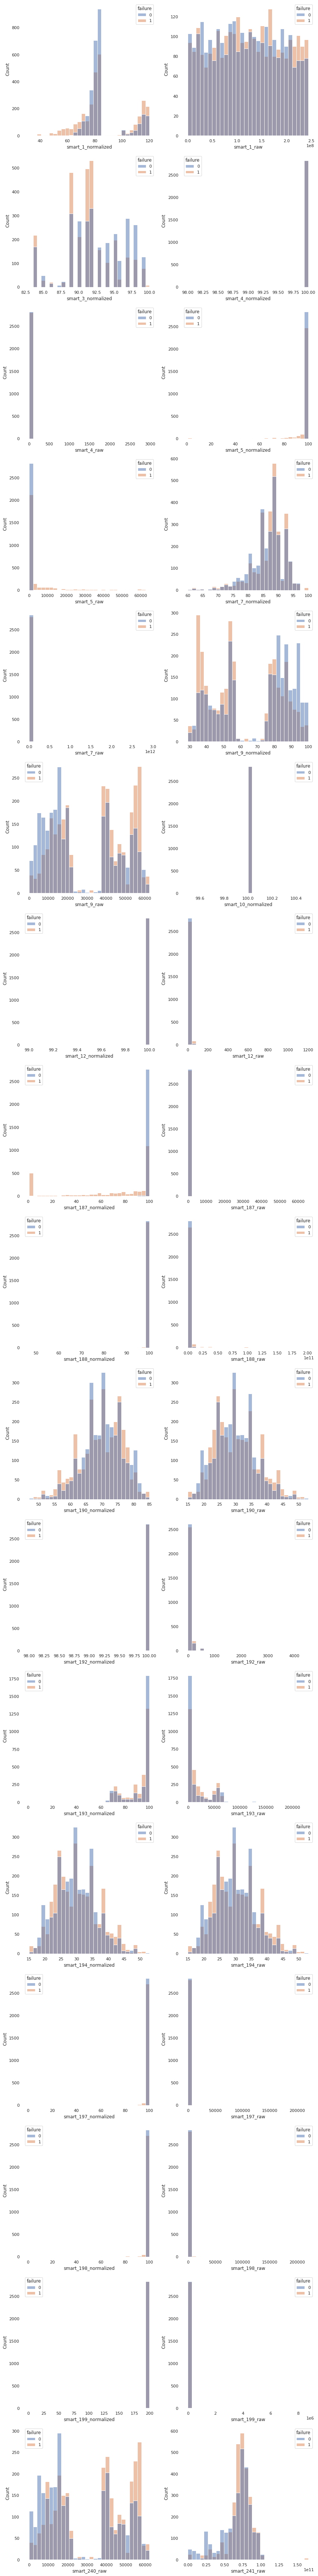

In [51]:
# References
# https://engineeringfordatascience.com/posts/matplotlib_subplots/
fig, axs = plt.subplots(nrows=17, ncols=2, 
                        figsize=(12, 96))

# A 'for' loop iterates through each column in the column list
# ('smart_col_list) and each ax in the axs, and creates a histogram
# plot for each column in the Pandas DataFrame 
# ('y2021_seagate_sample_df'), with 'failure' as the hue, and 30 bins,
# to the ax.
for col, ax in zip(smart_col_list, axs.ravel()):
    sns.histplot(data=q1_2022_seagate_sample_df, 
                 x=col, hue='failure', bins=30, ax=ax)
    fig.tight_layout()

The violin plots reveal that there are features with more failures in various ranges. For instance, the `smart_5_normalized` feature has failures (`1`) in the lower ranges (0-80) and the `smart_5_raw` feature has failures (`1`) in the higher ranges (50,000-70,000). Similar trends can be observed in the `smart_187`, `smart_188`, `smart_194`, `smart_197`, `smart_198`, and `smart_199` features.  

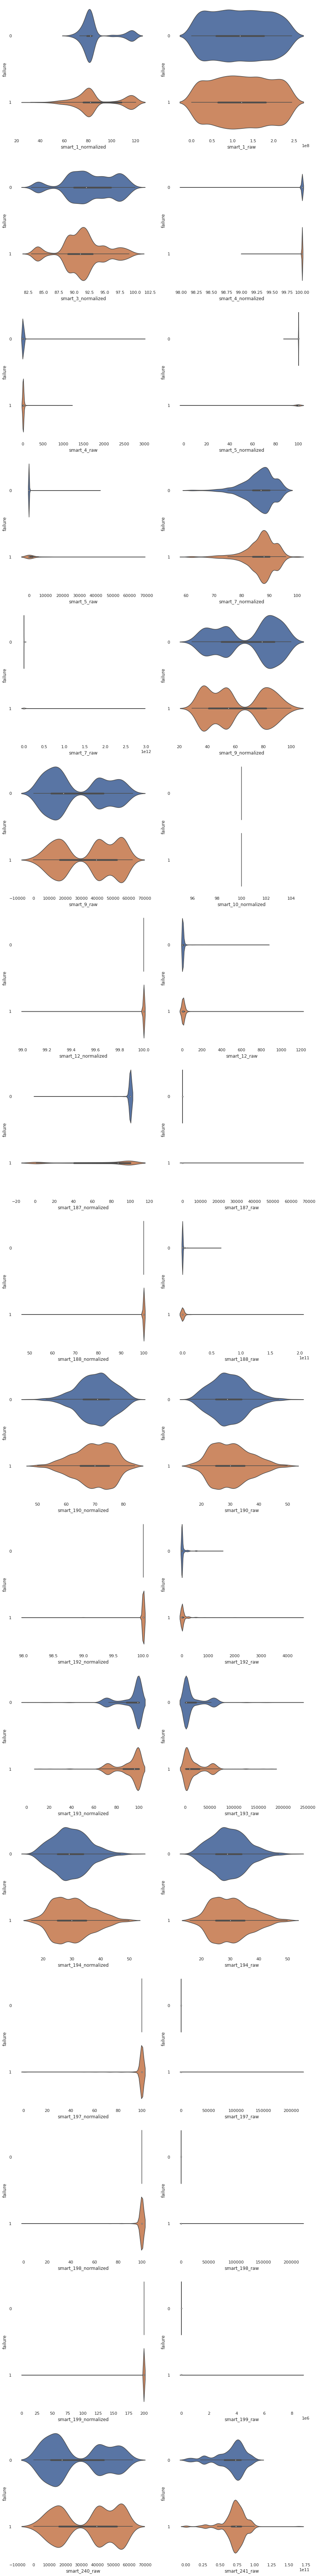

In [52]:
# References
# https://engineeringfordatascience.com/posts/matplotlib_subplots/
fig, axs = plt.subplots(nrows=17, ncols=2, 
                        figsize=(12, 96))

# A 'for' loop iterates through each column in the column list
# ('smart_col_list) and each ax in the axs, and creates a violin
# plot for each column in the Pandas DataFrame 
# ('y2021_seagate_sample_df'), with 'failure' as the hue to the ax.
for col, ax in zip(smart_col_list, axs.ravel()):
    sns.violinplot(data=q1_2022_seagate_sample_df, 
                       x=col, y='failure', ax=ax)
    fig.tight_layout()

***

## Features with excessive `zeros`  

Previously, some features indicated excessive zeros. A closer examination of the columns indicate 8 columns with excessive amounts of zeros (greater than 20%). However, one of the columns is the target feature (`failure`) and the `0` is an indicator of `non-functional`. The `failure` feature will not be included in further investigation.  

In [53]:
# References
# https://stackoverflow.com/questions/35829211/pandas-counting-the-proportion-of-zeros-in-rows-and-columns-of-dataframe

# A Pandas DataFrame ('q1_2022_seagate_df') is returned when there is a 
# match to '0'. A count of '0' is performed on the columns ('index') 
# and returned as a Pandas DataFrame. The Pandas DataFrame index is 
# reset and the columns are renamed to 'index' and 'zero_count'. A 
# column ('zero_percent') is added and calcuated from the 'zero_count' 
# column and the length of the index of the Pandas DataFrame 
# ('q1_2022_seagate_df'). A query is used to only return columns with 
# 20% or more zeros.
(
    q1_2022_seagate_df[(q1_2022_seagate_df == 0)]
    .count(axis='index')
    .to_frame()
    .reset_index()
    .rename(columns={'index': 'columns', 0: 'zero_count'})
).assign(zero_percent=lambda x: x['zero_count'] / 
         len(q1_2022_seagate_df.index) * 100).query('zero_percent > 20')

,columns,zero_count,zero_percent
4,failure,9198292,99.97
11,smart_5_raw,8803323,95.68
20,smart_187_raw,8902516,96.75
22,smart_188_raw,8865802,96.36
26,smart_192_raw,2710008,29.45
32,smart_197_raw,9103639,98.94
34,smart_198_raw,9103639,98.94
36,smart_199_raw,9069509,98.57


Typically, a column with the majority of a single value adds minimal contribution to prediction and that column would be a candidate for removal.
<br>
However, Backblaze has identified the following SMART attributes as being informative in determining a drive failure (Klein, 2016).
<br>

| ATTRIBUTE | DESCRIPTION                   |
|-----------|-------------------------------|
| SMART 5   | Reallocated Sectors Count     |
| SMART 187 | Reported Uncorrectable Errors |
| SMART 188 | Command Timeout               |
| SMART 197 | Current Pending Sector Count  |
| SMART 198 | Uncorrectable Sector Count    |

<br>
Research by Backblaze discovered that when the value of these SMART attributes is greater than zero, the potential for failure increases (Klein, 2016). When these SMART attributes are combined, the potential for being operational descreases (Klein, 2016).  
<br>
However, `smart_192_raw` and `smart_199_raw` are not considered as being informative by Backblaze and are candidates for removal. A decision has been made to allow feature selection techniques to remove these features.  

The `smart_5_raw` feature indicates 95.68% zeros of the data.  

In [54]:
top_5_values(q1_2022_seagate_df, 'smart_5_raw')

,smart_5_raw,total,percent
0,8803323,9201120,95.68
8,150019,9201120,1.63
16,45665,9201120,0.50
24,25238,9201120,0.27
32,18767,9201120,0.20


The `smart_187_raw` feature indicates 96.75% zeros of the data.  

In [55]:
top_5_values(q1_2022_seagate_df, 'smart_187_raw')

,smart_187_raw,total,percent
0,8902516,9201120,96.75
3,68520,9201120,0.74
1,36332,9201120,0.39
6,20344,9201120,0.22
7,19948,9201120,0.22


The `smart_188_raw` feature indicates 96.36% zeros of the data.  

In [56]:
top_5_values(q1_2022_seagate_df, 'smart_188_raw')  

,smart_188_raw,total,percent
0,8865802,9201120,96.36
4295032833,129481,9201120,1.41
8590065666,27849,9201120,0.30
1,27208,9201120,0.30
12885098499,11217,9201120,0.12


The `smart_192_raw` feature indicates 29.45% zeros of the data.  

In [57]:
top_5_values(q1_2022_seagate_df, 'smart_192_raw')

,smart_192_raw,total,percent
0,2710008,9201120,29.45
1,2007327,9201120,21.82
2,1056548,9201120,11.48
3,492995,9201120,5.36
4,270889,9201120,2.94


The `smart_197_raw` feature indicates 98.94% zeros of the data.  

In [58]:
top_5_values(q1_2022_seagate_df, 'smart_197_raw')

,smart_197_raw,total,percent
0,9103639,9201120,98.94
8,55507,9201120,0.60
16,16626,9201120,0.18
24,6564,9201120,0.07
32,3849,9201120,0.04


The `smart_198_raw` feature indicates 98.94% zeros of the data. The same percent as the `smart_197_raw` feature.  

In [59]:
top_5_values(q1_2022_seagate_df, 'smart_198_raw')

,smart_198_raw,total,percent
0,9103639,9201120,98.94
8,55507,9201120,0.60
16,16626,9201120,0.18
24,6564,9201120,0.07
32,3849,9201120,0.04


The `smart_199_raw` feature indicates 98.57% zeros of the data.  

In [60]:
top_5_values(q1_2022_seagate_df, 'smart_199_raw')

,smart_199_raw,total,percent
0,9069509,9201120,98.57
1,18764,9201120,0.20
2,10922,9201120,0.12
3,9057,9201120,0.10
4,7048,9201120,0.08


Rather than remove the features, these features will be screened in the feature selection process.  

## Evaluate a pair plot by failure  

Due to the number of features, the features had to be broken down into smaller groups. The `normalized` values were compared to `normalized` values and the `raw` values were compared to `raw` values. Once again for plotting, the sampled data was utilized.   

In review of the pair plots, a few features show separation of the target (`failure`):  
* smart_190_normalized x smart_193_normalized
* smart_193_normalized x smart_194_normalized
* smart_190_raw x smart_193_raw
* smart_193_raw x smart_194_raw  

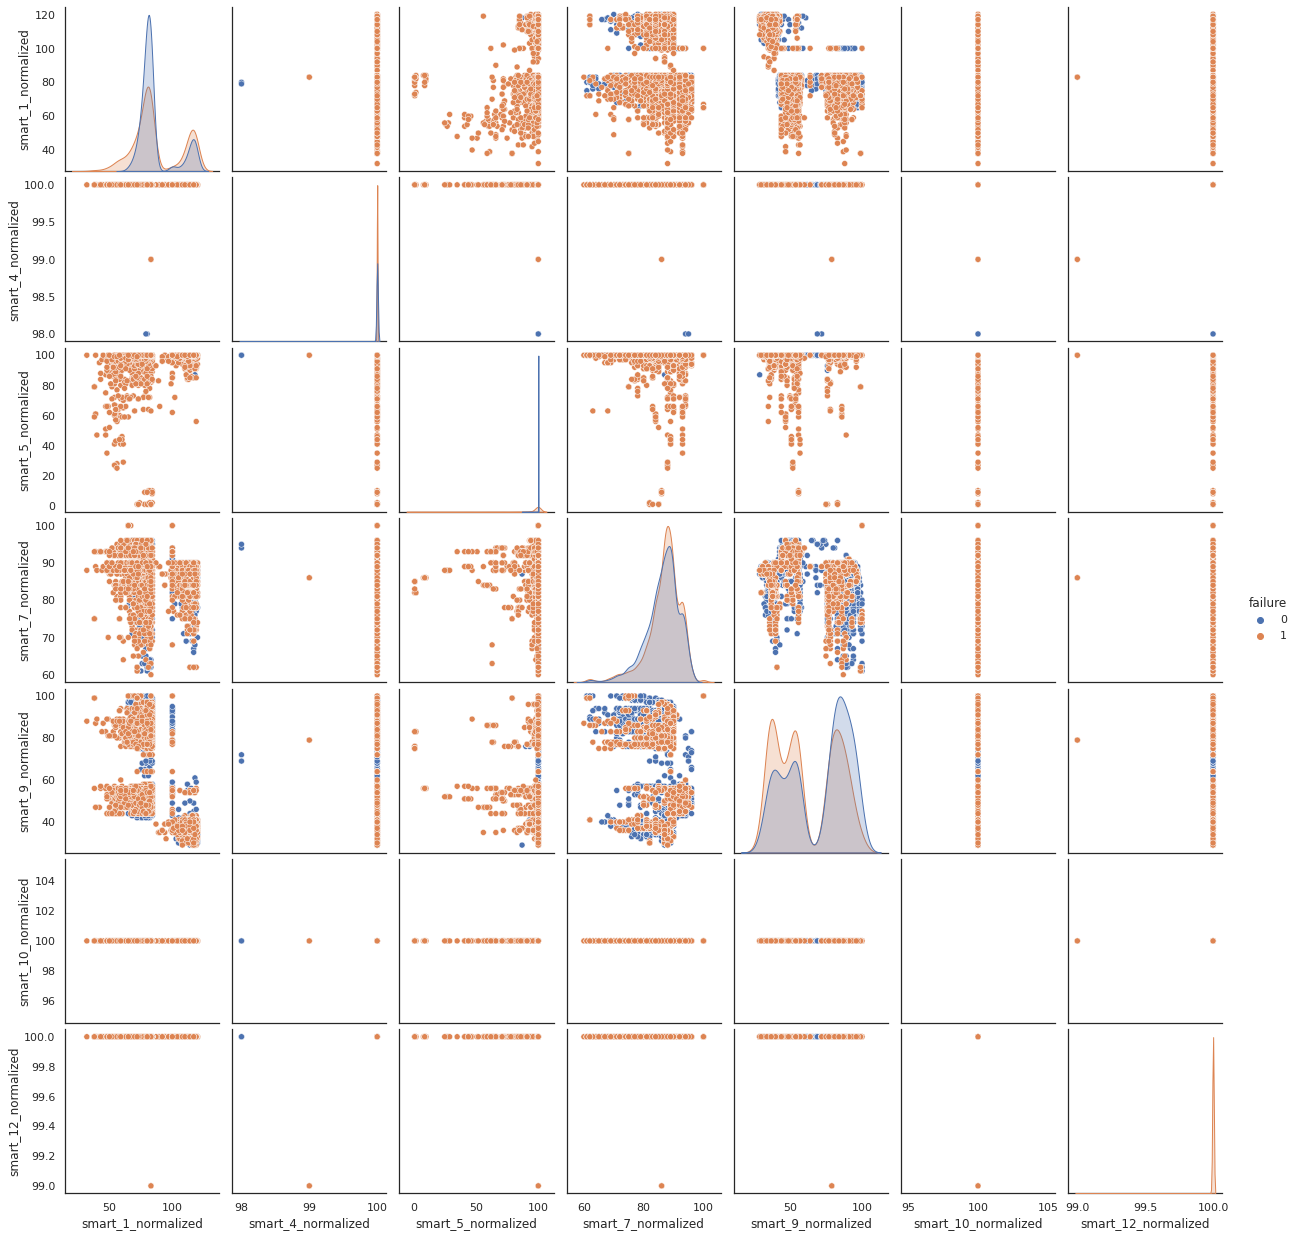

In [61]:
vars = ['smart_1_normalized', 'smart_4_normalized', 
        'smart_5_normalized', 'smart_7_normalized',
        'smart_9_normalized', 'smart_10_normalized',
        'smart_12_normalized',]

sns.pairplot(q1_2022_seagate_sample_df, hue='failure', vars=vars)
fig.tight_layout()

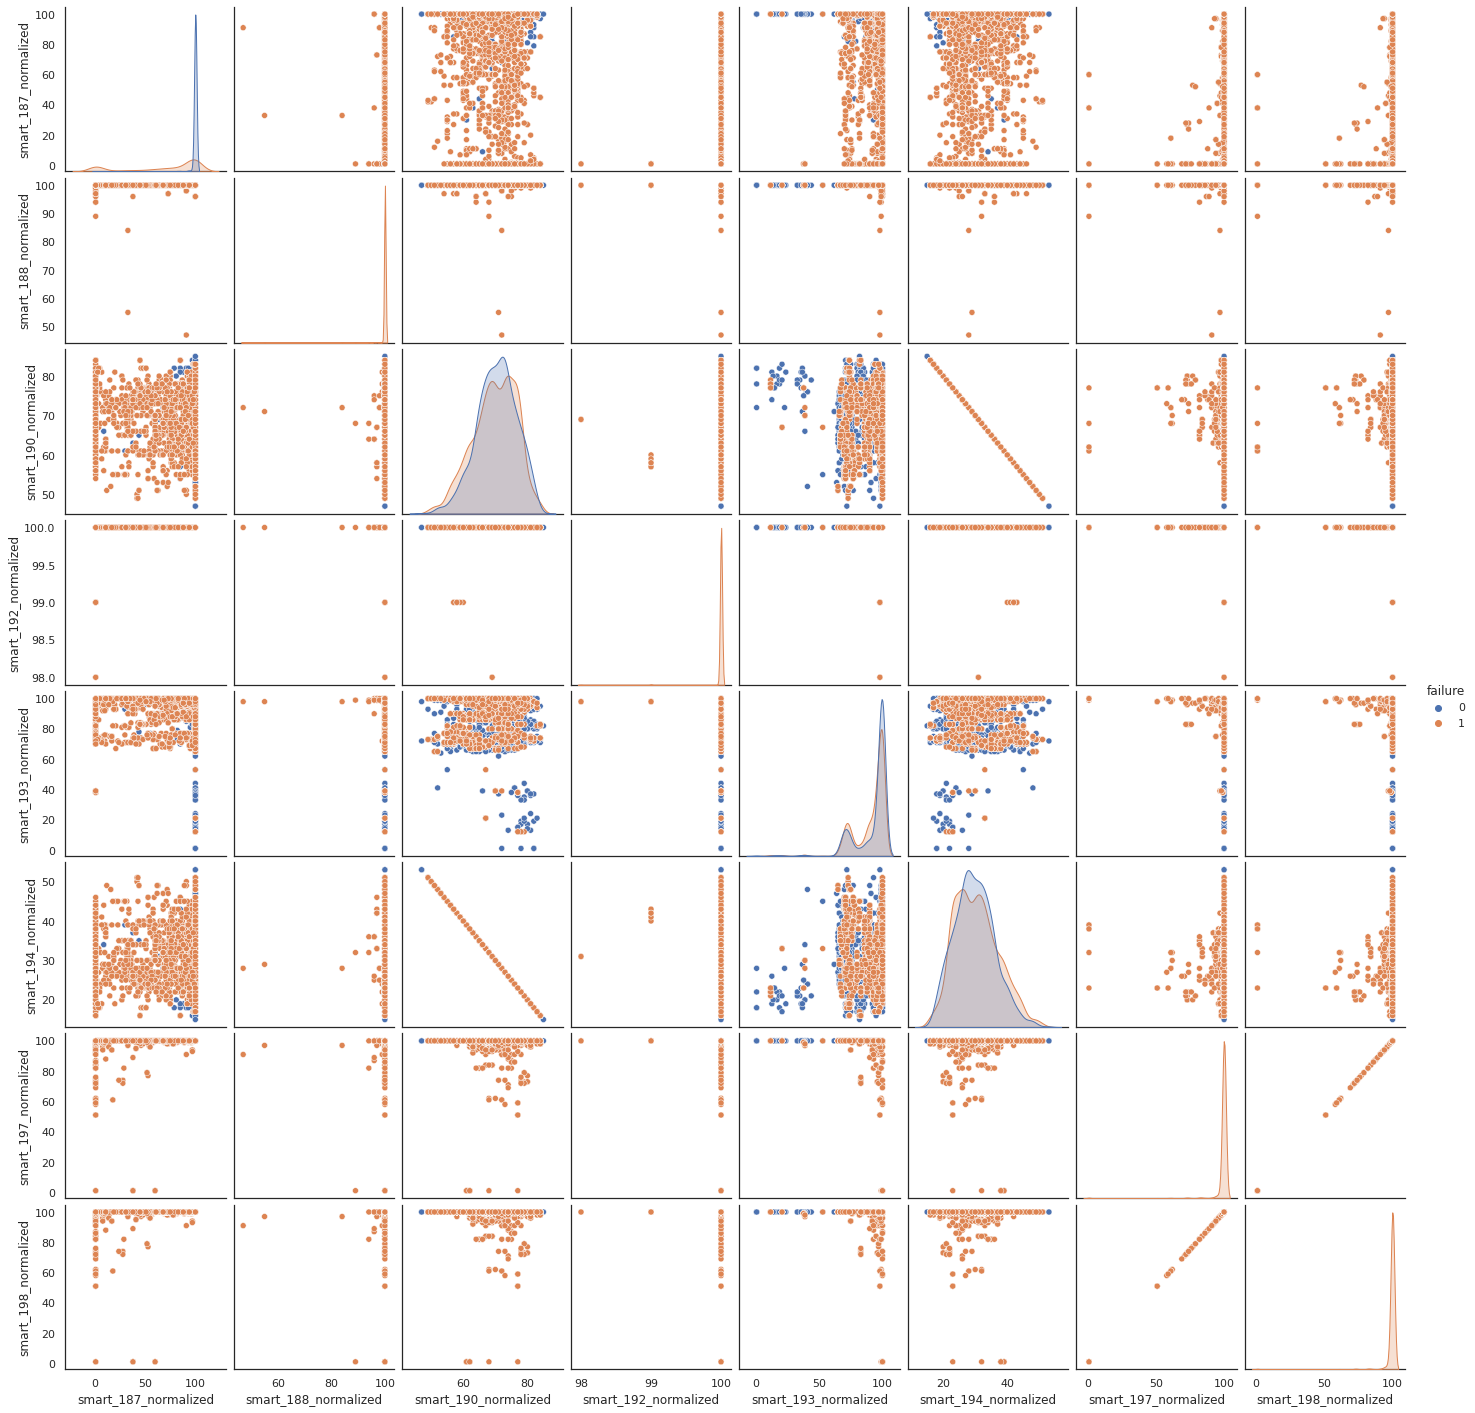

In [62]:
vars = ['smart_187_normalized', 'smart_188_normalized',
        'smart_190_normalized', 'smart_192_normalized',
        'smart_193_normalized', 'smart_194_normalized',
        'smart_197_normalized', 'smart_198_normalized']

sns.pairplot(q1_2022_seagate_sample_df, hue='failure', vars=vars)
fig.tight_layout()

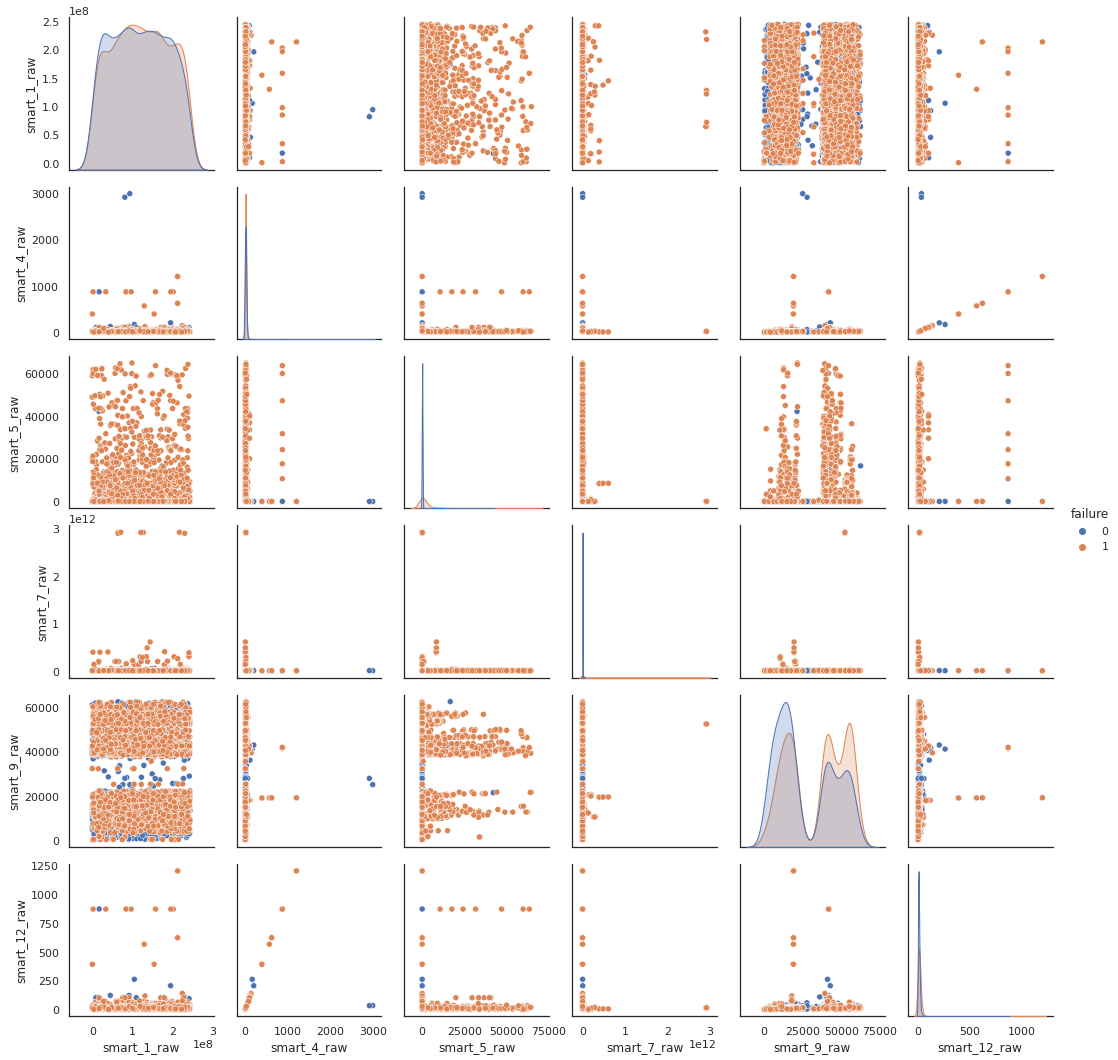

In [63]:
vars = ['smart_1_raw', 'smart_4_raw', 'smart_5_raw', 
        'smart_7_raw', 'smart_9_raw', 'smart_12_raw']

sns.pairplot(q1_2022_seagate_sample_df, hue='failure', vars=vars)
fig.tight_layout()

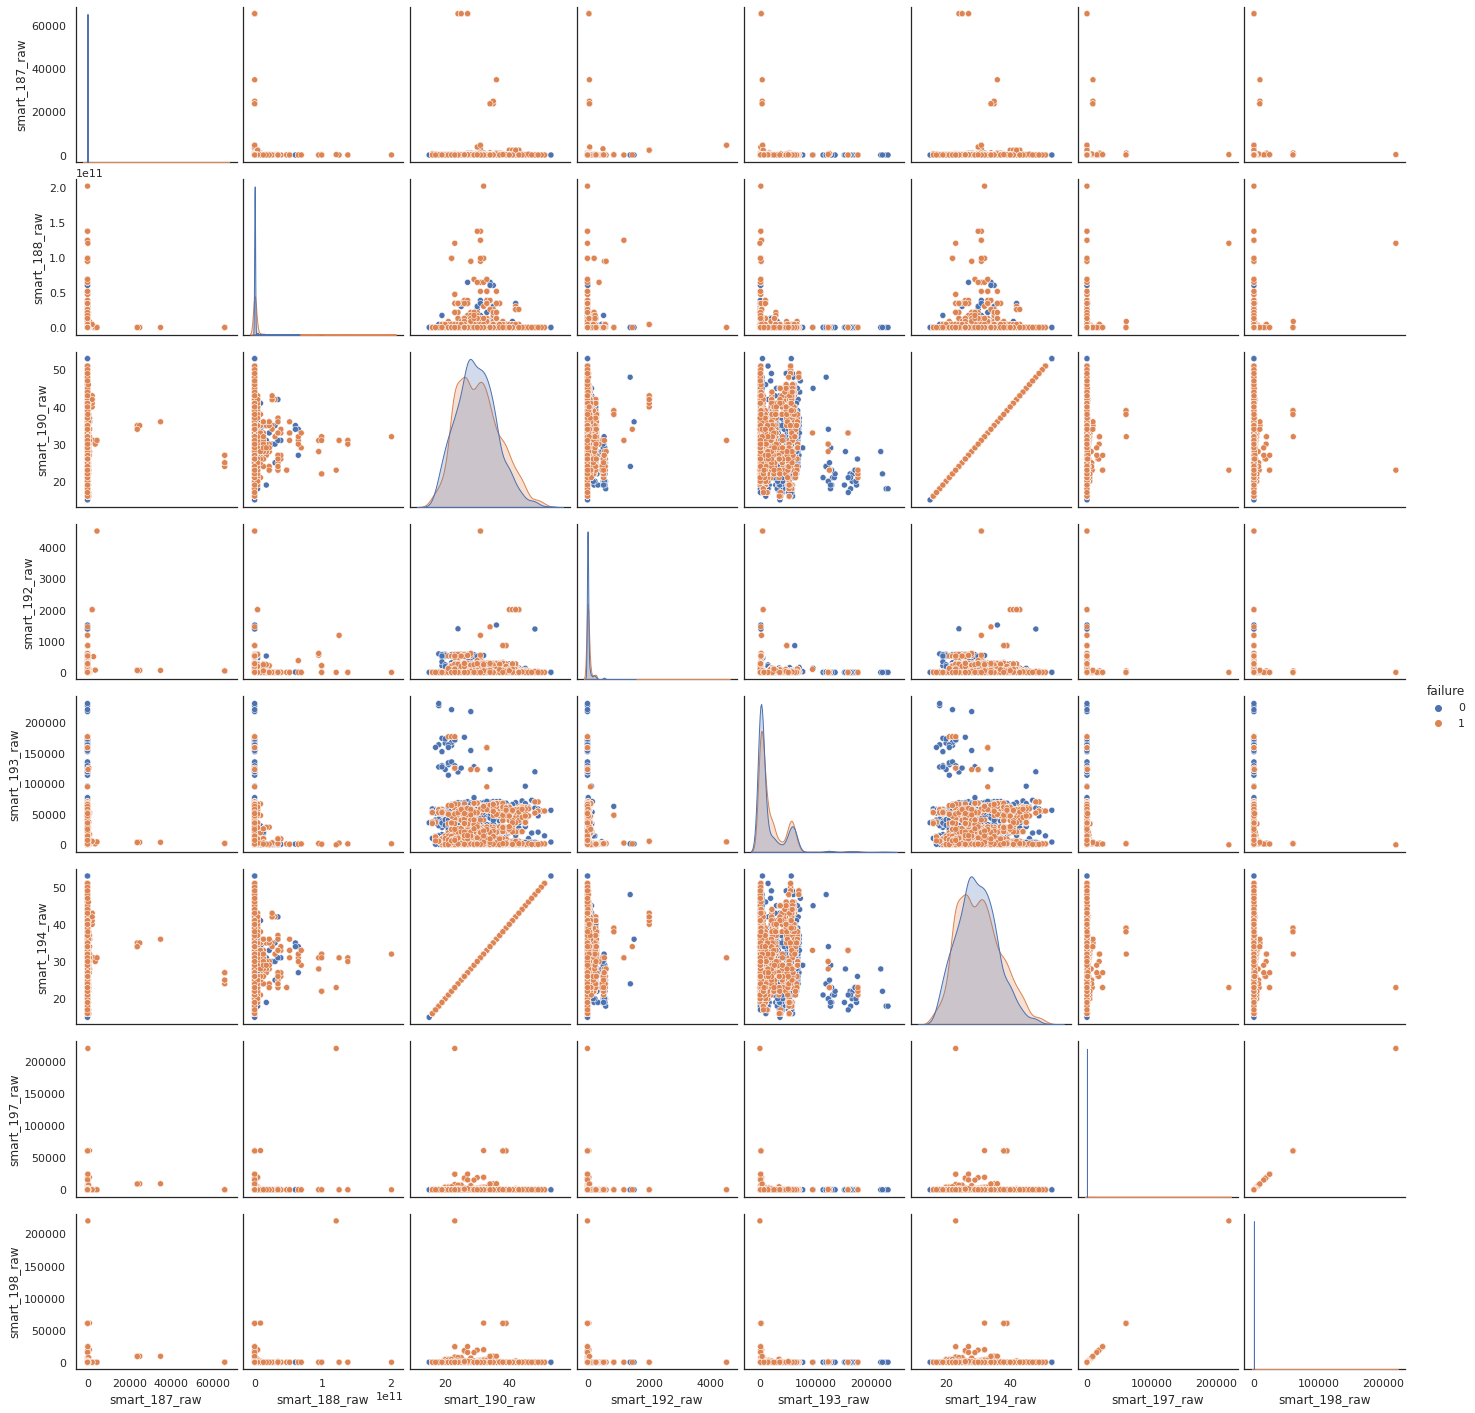

In [64]:
vars = ['smart_187_raw', 'smart_188_raw', 'smart_190_raw',
        'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 
        'smart_197_raw', 'smart_198_raw']

sns.pairplot(q1_2022_seagate_sample_df, hue='failure', vars=vars)
fig.tight_layout()

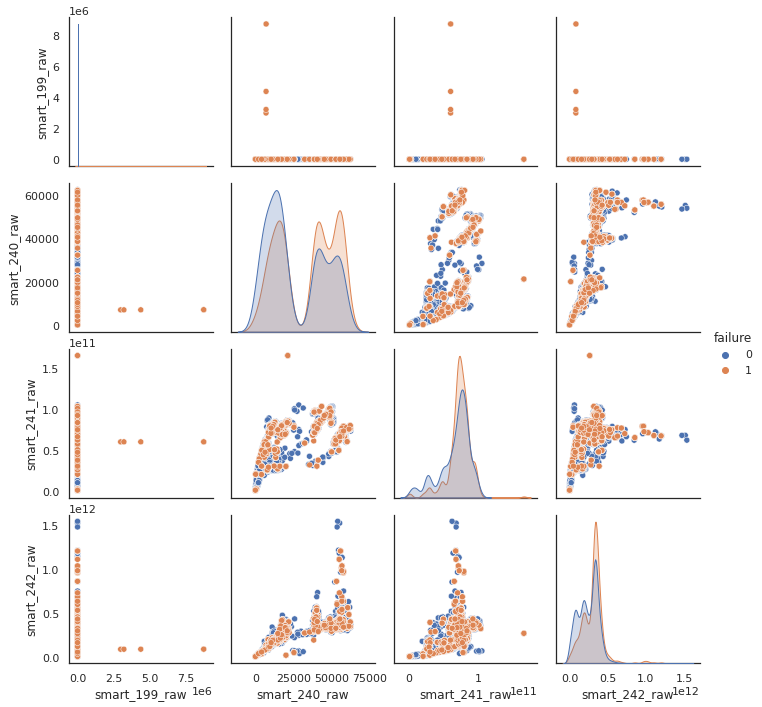

In [65]:
vars = ['smart_199_raw', 'smart_240_raw', 
        'smart_241_raw', 'smart_242_raw']

sns.pairplot(q1_2022_seagate_sample_df, hue='failure', vars=vars)
fig.tight_layout()

## Correlation plot  

A closer examination shows high correlation between the `normalized` and `raw` features. For example, `smart_4_normalized` and `smart_4_raw` have a negative correlation of -0.84 and `smart_9_normalized` and `smart_9_raw` have a negative correlation of -1.0. Because `normalized` values are derived from `raw` values this behavior is not unexpected.  There is also high correlation between other values. For instance, `smart_9_normalized` and `smart_240_raw` have a negative correlation of -1.0.  

In [66]:
# References
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

# A correlation matrix ('corr') is made of the Pandas DataFrame 
# ('q1_2022_seagate_sample_df'). 
corr = q1_2022_seagate_sample_df.corr()

In [67]:
corr

,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
smart_1_normalized,1.00,0.15,0.02,0.01,-0.01,0.16,-0.25,-0.15,0.05,-0.62,0.62,NaN,0.00,-0.00,-0.06,-0.06,0.04,-0.08,0.40,-0.40,0.01,-0.13,-0.09,0.09,-0.40,-0.40,-0.01,-0.04,-0.01,-0.04,0.01,-0.01,0.62,-0.09,0.41
smart_1_raw,0.15,1.00,-0.02,-0.00,0.00,-0.03,-0.00,0.00,0.01,-0.02,0.02,NaN,-0.03,0.02,-0.02,0.01,0.01,0.02,0.00,-0.00,0.00,0.01,-0.02,0.02,-0.00,-0.00,-0.03,0.02,-0.03,0.02,0.01,-0.02,0.02,0.05,0.02
smart_3_normalized,0.02,-0.02,1.00,0.00,-0.10,0.11,-0.20,-0.37,0.00,0.54,-0.54,NaN,-0.02,-0.15,0.16,-0.02,0.01,0.05,0.12,-0.12,-0.03,-0.05,0.48,-0.47,-0.12,-0.12,-0.04,0.05,-0.04,0.05,-0.02,0.03,-0.54,-0.50,-0.49
smart_4_normalized,0.01,-0.00,0.00,1.00,-0.84,-0.00,0.01,-0.02,0.00,-0.01,0.01,NaN,0.45,-0.24,-0.01,0.00,-0.00,-0.12,0.01,-0.01,-0.00,-0.07,0.02,-0.02,-0.01,-0.01,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.01,-0.02,-0.01
smart_4_raw,-0.01,0.00,-0.10,-0.84,1.00,-0.03,0.07,0.05,0.00,-0.05,0.05,NaN,-0.32,0.63,-0.05,0.01,-0.00,0.14,-0.03,0.03,0.01,0.17,-0.06,0.06,0.03,0.03,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.05,0.07,0.07
smart_5_normalized,0.16,-0.03,0.11,-0.00,-0.03,1.00,-0.59,-0.01,0.01,0.05,-0.05,NaN,-0.00,-0.05,0.34,-0.01,0.00,-0.02,0.08,-0.08,-0.00,-0.10,0.03,-0.03,-0.08,-0.08,-0.00,0.01,-0.00,0.01,-0.00,0.01,-0.05,-0.11,-0.06
smart_5_raw,-0.25,-0.00,-0.20,0.01,0.07,-0.59,1.00,0.05,-0.01,-0.08,0.08,NaN,0.01,0.12,-0.47,0.01,-0.01,-0.01,-0.12,0.12,-0.02,0.10,-0.08,0.08,0.12,0.12,0.01,-0.01,0.01,-0.01,0.00,-0.01,0.08,0.16,0.10
smart_7_normalized,-0.15,0.00,-0.37,-0.02,0.05,-0.01,0.05,1.00,-0.19,-0.23,0.23,NaN,0.00,0.05,0.03,0.02,0.02,-0.10,-0.12,0.12,0.00,-0.00,-0.36,0.36,0.12,0.12,0.07,-0.05,0.07,-0.05,0.01,-0.01,0.24,0.31,0.23
smart_7_raw,0.05,0.01,0.00,0.00,0.00,0.01,-0.01,-0.19,1.00,-0.03,0.03,NaN,0.00,0.00,-0.11,-0.00,-0.00,0.02,-0.01,0.01,0.00,-0.01,0.02,-0.02,0.01,0.01,-0.14,0.04,-0.14,0.04,0.00,-0.00,0.03,-0.01,0.02
smart_9_normalized,-0.62,-0.02,0.54,-0.01,-0.05,0.05,-0.08,-0.23,-0.03,1.00,-1.00,NaN,-0.01,-0.09,0.23,0.04,-0.04,0.11,-0.21,0.21,-0.04,0.03,0.54,-0.53,0.21,0.21,-0.01,0.04,-0.01,0.04,-0.02,0.03,-1.00,-0.42,-0.77


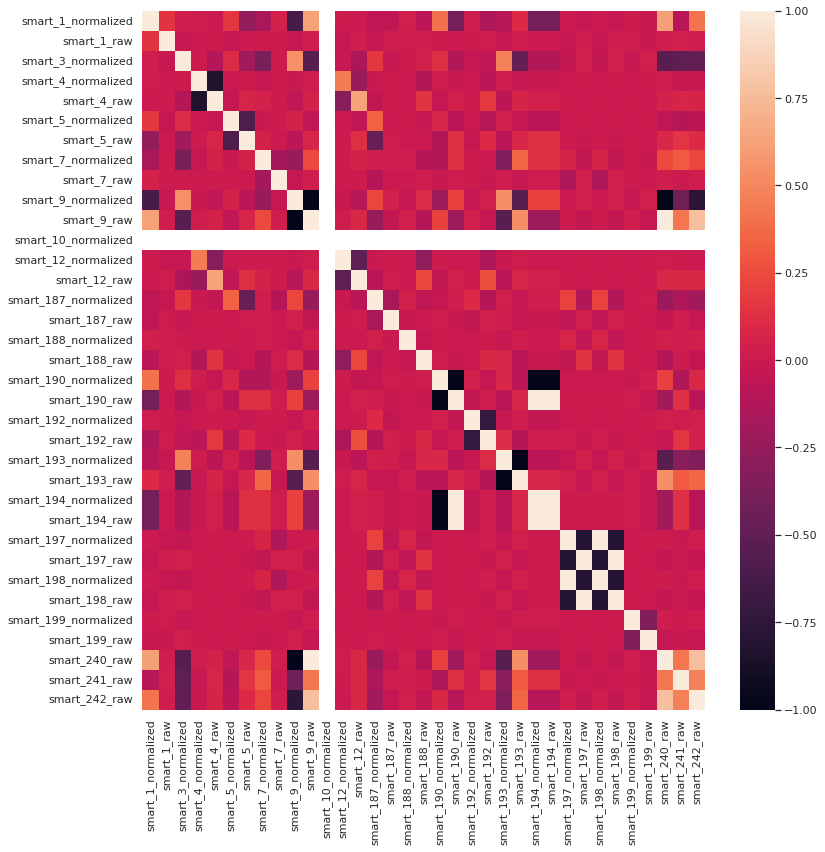

In [68]:
# References
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr)
fig.tight_layout()

Rather than remove the features, these features will be screened in the feature selection process.  

## Save the data to a Parquet file  

Previously observed, the `date` column no longer serves a purpose and is dropped from the data. The data is saved to a Parquet file.  

In [69]:
# The 'date' column is dropped from the Pandas DataFrame 
# ('q1_2022_seagate_df') in place.
q1_2022_seagate_df.drop(columns='date', inplace=True)
q1_2022_seagate_df

,serial_number_ltr,model,capacity_terabytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,S,ST4000DM000,4.00,0,111,41705776,91,100,26,100,0,87,564826045,38,55044,100,100,26,100,0,100,0,73,27,100,3,95,11576,27,27,100,0,100,0,200,0,54939,68556580648,370398316667
1,S,ST4000DM000,4.00,0,118,169130600,97,100,7,100,0,85,390128894,36,56329,100,100,3,100,0,100,0,72,28,100,0,76,49702,28,28,100,0,100,0,200,0,56060,67729811048,409848867140
2,S,ST4000DM000,4.00,0,118,189175216,92,100,12,100,0,83,208738421,34,58422,100,100,11,100,0,100,0,83,17,100,2,93,14304,17,17,100,0,100,0,200,0,58377,69088192984,714479920544
3,S,ST4000DM000,4.00,0,109,21882992,92,100,10,100,0,87,621911450,38,54620,100,100,10,100,0,100,0,84,16,100,0,93,15804,16,16,100,0,100,0,200,0,54564,60854732600,355300153266
4,S,ST4000DM000,4.00,0,117,154406968,92,100,11,100,0,82,187608333,38,54620,100,100,11,100,0,100,0,82,18,100,0,94,12487,18,18,100,0,100,0,200,0,54576,55863048616,338697039483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9201115,Z,ST12000NM001G,12.00,0,80,109909024,99,100,1,100,0,87,487341148,95,5019,100,100,1,100,0,100,0,69,31,100,0,100,211,31,31,100,0,100,0,200,0,4996,33747256368,47906088444
9201116,Z,ST12000NM001G,12.00,0,76,38585856,97,100,3,100,0,84,256187033,97,2939,100,100,3,100,0,100,0,79,21,100,0,100,135,21,21,100,0,100,0,200,0,2921,24066520400,96578036396
9201117,Z,ST10000NM001G,10.00,0,75,32309592,98,100,2,100,0,79,84623606,99,1036,100,100,2,100,0,100,0,74,26,100,0,100,49,26,26,100,0,100,0,200,0,1029,22340154600,14069767910
9201118,Z,ST12000NM001G,12.00,0,76,41882280,99,100,1,100,0,77,46770891,100,407,100,100,1,100,0,100,0,66,34,100,0,100,22,34,34,100,0,100,0,200,0,405,22682193752,5924259866


In [70]:
# References
# https://pandas.pydata.org/pandas-docs/version/1.1/reference/api/pandas.DataFrame.to_parquet.html

# The Pandas DataFrame ('q1_2022_seagate_df') is saved to a Parquet 
# file ('q1_2022_seagate_eda.parquet') for machine learning.
(
    q1_2022_seagate_df
    .to_parquet('./data/parquet/q1_2022_seagate_eda.parquet')
)

## Summary  

In summation, the data was read from a Parquet file into a PyArrow table and converted to a Pandas DataFrame. Descriptive statistics were calculated on categorical and numerical data types. Unique values were assessed and the `serial_number` feature revealed a high number of unique values that presented potential issues with high cardinality. The `serial_number` feature was engineered to group the serial number by the first letter, which created 3 bins (groups). Unique values were also assessed for numerical features and there were no features that had only 1 unique value. There was one feature with a minimum of 2 unique values. The presence of duplicates were also evaluated and none exist. Features were further examined through aggregation and plotting. The categorical features were inspected with bar charts. In order to plot the numerical features, the data was sampled. The numerical features were inspected through the use of histograms and violin plots. Features with excessive zeros were also detected. However, Backblaze research determined most of these features are deemed as important (Klein, 2016). Rather than remove the features, the features will be scrutinized in the feature selection process. Pairwise plots and correlation plots were utilized for bivariate analysis. The pairwise plots revealed some separation of the classes that could contribute to the classification. The correlation plot displayed features with high correlation, which will also be scrutinized in the feature selection process. Lastly, the `date` feature was removed from the data due to insignificance and the data was saved to a Parquet file.  

## Please shutdown kernel to free up memory or uncomment the cell below and run. 

In [71]:
#quit()

## <center>References</center>  

Klein, A. (2016, October 6). <i>What SMART stats tell us about hard drives.</i> Backblaze Blog.  https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/  
<br>
S.M.A.R.T. (2022, September 9). In <i>Wikipedia</i>. https://en.wikipedia.org/w/index.php?title=S.M.A.R.T.&oldid=1109378579  
<br>